Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


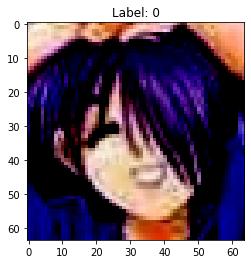

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the transforms to be applied to the images
std = (0.5,0.5,0.5)
mean = (0.5,0.5,0.5)
image_size = 64
transform = transforms.Compose(
    [transforms.Resize(image_size),
     transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize(mean,std)] # Normalize with mean and std
)

# Load the training dataset
batch_size = 32
trainset = ImageFolder(root = './images', transform=transform)

# Create a data loader for the training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

# Get one or two images from the training set
image, label = trainset[0]
print(image.shape)
image = image.permute(1, 2, 0)

# Visualize the image
plt.imshow(image, cmap='gray')
plt.title('Label: {}'.format(label))
plt.show()
        
num_channels = 3
flat_size = image_size*image_size*num_channels # a sample in the trainset is a square image of 32*32, and 3 color channels.


In [5]:

class UNet(nn.Module):
    def __init__(self, in_channels=3):
        super(UNet, self).__init__()
        
        # Downsample layers
        expand0 = 16
        self.conv1 = DoubleConv(in_channels, expand0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = DoubleConv(expand0, 2*expand0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = DoubleConv(2*expand0, 4*expand0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = DoubleConv(4*expand0, 8*expand0)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Upsample layers
        self.up5 = nn.ConvTranspose2d(8*expand0, 4*expand0, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(8*expand0, 4*expand0)
        self.up6 = nn.ConvTranspose2d(4*expand0, 2*expand0, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(4*expand0, 2*expand0)
        self.up7 = nn.ConvTranspose2d(2*expand0, expand0, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(2*expand0, expand0)
        
        # Output layer
        self.out = nn.Conv2d(expand0, in_channels, kernel_size=1)
        
    def forward(self, x):
        # Downsample
        x1 = self.conv1(x)
        x2 = self.pool1(x1)
        #print(f"x2 is {x2.shape}")
        x2 = self.conv2(x2)
        x3 = self.pool2(x2)
        x3 = self.conv3(x3)
        x4 = self.pool3(x3)
        x4 = self.conv4(x4)  
        #print(f"x4 is {x4.shape}")
              
        # Upsample
        x5 = self.up5(x4)
        #print(f"x5 is {x5.shape}")
        #print(f"x3 is {x3.shape}")        
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.conv5(x5)
        x6 = self.up6(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.conv6(x6)
        x7 = self.up7(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.conv7(x7)
        
        # Output
        out = self.out(x7)
        out = nn.Tanh()(out)
        return out

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Discriminator(nn.Module):
    def __init__(self, num_channels):
        super(Discriminator, self).__init__()
        # Downsample layers
        expand0 = 16
        self.conv1 = DoubleConv(num_channels, expand0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = DoubleConv(expand0, 2*expand0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = DoubleConv(2*expand0, 4*expand0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = DoubleConv(4*expand0, 8*expand0)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Upsample layers
        self.up5 = nn.ConvTranspose2d(8*expand0, 4*expand0, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(8*expand0, 4*expand0)
        self.up6 = nn.ConvTranspose2d(4*expand0, 2*expand0, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(4*expand0, 2*expand0)
        self.up7 = nn.ConvTranspose2d(2*expand0, expand0, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(2*expand0, expand0)
        
        # Output layer
        self.out = nn.Conv2d(expand0, 1, kernel_size=64,stride=1,padding=0)
        
    def forward(self, x):
        # Downsample
        x1 = self.conv1(x)
        x2 = self.pool1(x1)
        #print(f"x2 is {x2.shape}")
        x2 = self.conv2(x2)
        x3 = self.pool2(x2)
        x3 = self.conv3(x3)
        x4 = self.pool3(x3)
        x4 = self.conv4(x4)  
        #print(f"x4 is {x4.shape}")
              
        # Upsample
        x5 = self.up5(x4)
        #print(f"x5 is {x5.shape}")
        #print(f"x3 is {x3.shape}")        
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.conv5(x5)
        x6 = self.up6(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.conv6(x6)
        x7 = self.up7(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.conv7(x7)
        out = self.out(x7)
        out = nn.Flatten()(out)
        out = nn.Sigmoid()(out)
        
        # Output

        return out


# Define the loss function
#criterion = nn.BCELoss()



# Define the optimizers
lr_dis = 0.0005
lr_gen = 0.0001
beta1 = 0.5
beta2 = 0.999

# define the models:
generator = UNet().to(device)
discriminator = Discriminator(num_channels=3).to(device)

# Define the loss function and optimizer for the discriminator
criterion_D = nn.BCELoss()

# Define the loss function and optimizer for the generator
criterion_G = nn.BCELoss()

# Create the generator optimizer
#optimizer_G = torch.optim.SGD(generator.parameters(), lr=lr_gen)
optimizer_G = torch.optim.Adam(generator.parameters(),  lr=lr_gen, betas=(beta1, beta2))



# Create the discriminator optimizer
#optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=lr_dis)
optimizer_D = torch.optim.Adam(discriminator.parameters(),  lr=lr_dis, betas=(beta1, beta2))


In [6]:
num_epochs = 5
#print("debug chk")
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(trainloader):
        # Train the discriminator
        discriminator.zero_grad()
        real_images = images.to(device)
        #print(f"size of real_images is {real_images.shape}")        
        real_labels = torch.ones(batch_size, 1).to(device)
        noise_input_D = torch.randn(batch_size, num_channels, image_size,image_size).to(device)
        fake_images = generator(noise_input_D).detach()
        #print(f"size of fake_images is {fake_images.shape}")
        fake_labels = torch.zeros(batch_size, 1).to(device)
        inputchk = discriminator(real_images)
        discriminator_loss_real = criterion_D(discriminator(real_images), real_labels)
        discriminator_loss_fake = criterion_D(discriminator(fake_images), fake_labels)
        discriminator_loss = discriminator_loss_real + discriminator_loss_fake
        discriminator_loss.backward()
        optimizer_D.step()

        # Train the generator
        generator.zero_grad()
        noise_input_G = torch.randn(batch_size, num_channels, image_size,image_size).to(device)        
        fake_images = generator(noise_input_G)
        generator_loss = criterion_G(discriminator(fake_images), real_labels)
        generator_loss.backward()
        optimizer_G.step()

        if i % 50 == 0:
            print(f"Iteration {i} Epoch {epoch}: D Loss = {discriminator_loss}, G Loss = {generator_loss} ")
            
        if abs(i-len(trainloader)) <= batch_size:
            break          

Iteration 0 Epoch 0: D Loss = 1.532454013824463, G Loss = 0.4286848306655884 
Iteration 50 Epoch 0: D Loss = 0.0137183154001832, G Loss = 5.823954105377197 
Iteration 100 Epoch 0: D Loss = 2.2028863430023193, G Loss = 20.12741470336914 
Iteration 150 Epoch 0: D Loss = 0.014658145606517792, G Loss = 16.51302146911621 
Iteration 200 Epoch 0: D Loss = 0.00041368804522790015, G Loss = 16.095434188842773 
Iteration 250 Epoch 0: D Loss = 1.6875827668627608e-06, G Loss = 45.58674240112305 
Iteration 300 Epoch 0: D Loss = 0.00033678102772682905, G Loss = 39.38243865966797 
Iteration 350 Epoch 0: D Loss = 1.862645504502325e-08, G Loss = 37.34212875366211 
Iteration 400 Epoch 0: D Loss = 1.315863300987985e-05, G Loss = 37.00148010253906 
Iteration 450 Epoch 0: D Loss = 0.0, G Loss = 36.38695526123047 
Iteration 500 Epoch 0: D Loss = 4.670182228088379, G Loss = 81.8446044921875 
Iteration 550 Epoch 0: D Loss = 0.0, G Loss = 61.283897399902344 
Iteration 600 Epoch 0: D Loss = 0.0, G Loss = 57.6828

KeyboardInterrupt: 

In [ ]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")     

torch.Size([64, 64, 3])


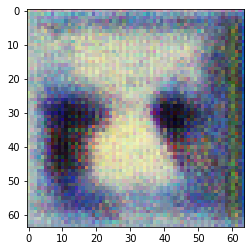

In [38]:

# Generate some images
generator = generator.to("cpu")
with torch.no_grad():
    noise_input_test = torch.randn(1, 3, 64,64)   
    generated_images = generator(noise_input_test)
    image_for_plot = generated_images.squeeze()
    image_for_plot = image_for_plot.permute(1, 2, 0)
    image_for_plot = image_for_plot*0.5 + 0.5
print(image_for_plot.shape)
plt.imshow(image_for_plot,cmap='gray')
plt.show()
